In [179]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#import wrangle
import env
import seaborn as sns
import acquire
import prep
import scipy.stats as stats
import matplotlib.pyplot as plt

In [138]:
#single family residence from zillow DB
df = prep.prep_df()

In [139]:
df.isnull().sum().sort_values(ascending=False)

logerror                      0
structuretaxvaluedollarcnt    0
yearbuilt                     0
regionidzip                   0
regionidcounty                0
regionidcity                  0
lotsizesquarefeet             0
longitude                     0
latitude                      0
fips                          0
tax_value                     0
sqft                          0
bedrooms                      0
bathrooms                     0
dtype: int64

In [140]:
#drops columns with < 80% of values filled in
#df = prep.impute_values(df)
#df = prep.drop_columns(df)
#11/7 - prep_df() already completes these tasks

In [141]:
#df = df.dropna(how='any')
#11/7 - prep_df() already completes this task. 

In [142]:
#test = df[(df.propertycountylandusecode != "010G") & ((df.propertycountylandusecode != "010M"))]

#test.propertycountylandusecode.astype(float)
#11/7 

In [143]:
#test = df[(df.propertycountylandusecode == "010G") | ((df.propertycountylandusecode == "010M"))]

#test.shape
#11/7 df.propertycountylandusecode does not exist, column was dropped prior to it being summoned prep_df()

In [144]:
#df[['landtaxvaluedollarcnt','lotsizesquarefeet']].head()
#11/7 - landtaxvaluedollarcnt does not exist, column was dropped prior to it being summoned by prep_df()

In [145]:
#df['tax_value_per_foot'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet
#df.tax_value_per_foot.mean()
#11/7 - landtaxvaluedollarcnt does not exist, column was dropped prior to it being summoned by prep_df()

In [146]:
(df.structuretaxvaluedollarcnt/df.tax_value).mean()

0.44655075425543933

In [147]:
df.head().T

,0,1,2,3,4
bathrooms,2.000000e+00,4.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00
bedrooms,4.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
sqft,3.633000e+03,1.620000e+03,2.077000e+03,1.244000e+03,1.300000e+03
tax_value,2.964250e+05,8.477700e+05,6.467600e+05,1.694710e+05,2.332660e+05
fips,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03,6.037000e+03
latitude,3.456002e+07,3.399620e+07,3.401298e+07,3.395356e+07,3.389713e+07
longitude,-1.181698e+08,-1.184380e+08,-1.184792e+08,-1.180839e+08,-1.181030e+08
lotsizesquarefeet,9.826000e+03,1.284275e+04,6.490000e+03,6.021000e+03,4.917000e+03
regionidcity,4.022700e+04,1.244700e+04,2.696400e+04,1.371600e+04,5.363600e+04
regionidcounty,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03,3.101000e+03


In [148]:
df.lotsizesquarefeet.head()

0     9826.000000
1    12842.749037
2     6490.000000
3     6021.000000
4     4917.000000
Name: lotsizesquarefeet, dtype: float64

In [149]:
#df.landtaxvaluedollarcnt /df.tax_value_per_foot.mean()
#11/7 - landtaxvaluedollarcnt does not exist, column was dropped prior to it being summoned by prep_df()

In [150]:
# df_nulls_r = pd.DataFrame(df.apply(lambda x: df.shape[1] -x.count(),axis=1))
# df_nulls_r['pct_rows_missing'] = df_nulls_r[0] / df.shape[1]
# row_drops = df_nulls_r[df_nulls_r['pct_rows_missing'] >.2]
# row_drops['column_names'] = row_drops.index
# row_drops = list(row_drops.column_names)
# #df_new = df.drop(row_drops,axis=0)

# df_nulls_r.max()


In [151]:
Q1 = df.quantile(.25)
Q3 = df.quantile(.75)
IQR = Q3-Q1

In [152]:
IQR = Q3-Q1
Q1

bathrooms                     2.000000e+00
bedrooms                      3.000000e+00
sqft                          1.260000e+03
tax_value                     1.874700e+05
fips                          6.037000e+03
latitude                      3.383746e+07
longitude                    -1.184017e+08
lotsizesquarefeet             5.677000e+03
regionidcity                  1.244700e+04
regionidcounty                2.061000e+03
regionidzip                   9.619300e+04
yearbuilt                     1.949000e+03
structuretaxvaluedollarcnt    7.515900e+04
logerror                     -2.443694e-02
Name: 0.25, dtype: float64

In [153]:
df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

,bathrooms,bedrooms,sqft,tax_value,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,logerror
1,4.0,3.0,1620.0,847770.0,6037.0,33996200.0,-118438000.0,12842.749037,12447.0,3101.0,96047.0,2011.0,339532.0,-0.019546
2,2.0,3.0,2077.0,646760.0,6037.0,34012977.0,-118479243.0,6490.000000,26964.0,3101.0,96152.0,1926.0,210192.0,-0.040807
3,1.0,3.0,1244.0,169471.0,6037.0,33953559.0,-118083855.0,6021.000000,13716.0,3101.0,96201.0,1950.0,108040.0,0.042412
4,2.0,3.0,1300.0,233266.0,6037.0,33897134.0,-118102953.0,4917.000000,53636.0,3101.0,96193.0,1950.0,77415.0,-0.000908
744,2.0,3.0,1766.0,390038.0,6037.0,34217790.0,-118628236.0,9085.000000,12447.0,3101.0,96339.0,1962.0,120205.0,0.012474
747,3.0,4.0,2397.0,537750.0,6037.0,34212078.0,-118638939.0,12910.000000,12447.0,3101.0,96339.0,1984.0,274403.0,0.005598
748,3.0,4.0,2574.0,533947.0,6037.0,34217005.0,-118643730.0,10095.000000,12447.0,3101.0,96339.0,1981.0,239616.0,-0.094197
750,3.0,4.0,2661.0,433253.0,6037.0,34214457.0,-118639462.0,9787.000000,12447.0,3101.0,96339.0,1983.0,258245.0,0.049512
751,3.0,4.0,1830.0,435890.0,6037.0,34201279.0,-118623456.0,8280.000000,12447.0,3101.0,96342.0,1960.0,132311.0,0.028396
752,2.0,3.0,1358.0,371255.0,6037.0,34206413.0,-118618965.0,7551.000000,12447.0,3101.0,96342.0,1956.0,103875.0,0.026857


In [154]:
def outlier(series):
    Q1 = series.quantile(.25)
    Q3 = series.quantile(.75)
    IQR = Q3-Q1
    
    series = series[((series < (Q1 - 3 * IQR)) |(series > (Q3 + 3 * IQR)))]
    return series

In [155]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        q75, q25 = np.percentile(df[col], [75,25])
        ub = 3*stats.iqr(df[col]) + q75
        lb = q25 - 3*stats.iqr(df[col])
        print(len(df[df[col] <= ub]))
        df = df[df[col] <= ub]
        df = df[df[col] >= lb]
    return df

In [156]:
len(remove_outliers_iqr(df,['tax_value','sqft','lotsizesquarefeet','structuretaxvaluedollarcnt']))

52935
52686
49564
48919


48919

In [157]:
df.shape

(54544, 14)

In [158]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import prep
import seaborn as sns
from sklearn.cluster import KMeans
 

In [159]:
train, test = train_test_split(df, train_size = .75, random_state = 123)

In [160]:
train.head()

,bathrooms,bedrooms,sqft,tax_value,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,logerror
12854,2.0,3.0,1838.0,216159.0,6037.0,34613754.0,-118209598.0,9796.0,40227.0,3101.0,97329.0,1999.0,172934.0,0.051355
6103,2.0,3.0,2306.0,181378.0,6037.0,33764859.0,-118414326.0,10306.0,33311.0,3101.0,96121.0,1968.0,109124.0,0.005659
46884,2.0,3.0,1482.0,304562.0,6037.0,34153101.0,-118231483.0,6461.0,45457.0,3101.0,96325.0,1924.0,196565.0,0.052020
33177,3.0,4.0,1548.0,220704.0,6037.0,34216166.0,-118421991.0,7113.0,12447.0,3101.0,96450.0,1954.0,122037.0,0.093799
43799,2.0,3.0,1338.0,354795.0,6037.0,34205923.0,-118511561.0,5998.0,12447.0,3101.0,96415.0,1950.0,89675.0,-0.066423


In [161]:
X_train = train.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_train = train[['logerror']]
X_test = test.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_test = test[['logerror']]
X_train.tax_value = X_train.tax_value /1000
X_train.structuretaxvaluedollarcnt = X_train.structuretaxvaluedollarcnt/1000

In [101]:
from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=5)
#kmeans.fit(X_train)
#kmeans.predict(X_train)
#X_train['cluster'] = kmeans.predict(X_train)

In [28]:
pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt
cluster,,,,,,,
0,2.239730,3.305822,1850.48606,447.995707,8.384322e+03,1960.849934,173.690282
1,2.000000,3.000000,1000.00000,759.337000,6.845666e+06,1947.000000,16.418000
2,3.700000,4.000000,4462.70000,1784.633400,1.261119e+06,1974.600000,793.888800
3,2.000000,2.000000,1773.00000,61.041000,3.500297e+06,1946.000000,42.430000
4,3.345238,3.625850,3530.92517,1363.694905,1.553255e+05,1976.625850,614.316701


In [29]:
#X_train['cluster'] = kmeans.predict(X_train)
#X_train.head()

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,cluster
12854,2.0,3.0,1838.0,216.159,9796.0,1999.0,172.934,0
6103,2.0,3.0,2306.0,181.378,10306.0,1968.0,109.124,0
46884,2.0,3.0,1482.0,304.562,6461.0,1924.0,196.565,0
33177,3.0,4.0,1548.0,220.704,7113.0,1954.0,122.037,0
43799,2.0,3.0,1338.0,354.795,5998.0,1950.0,89.675,0


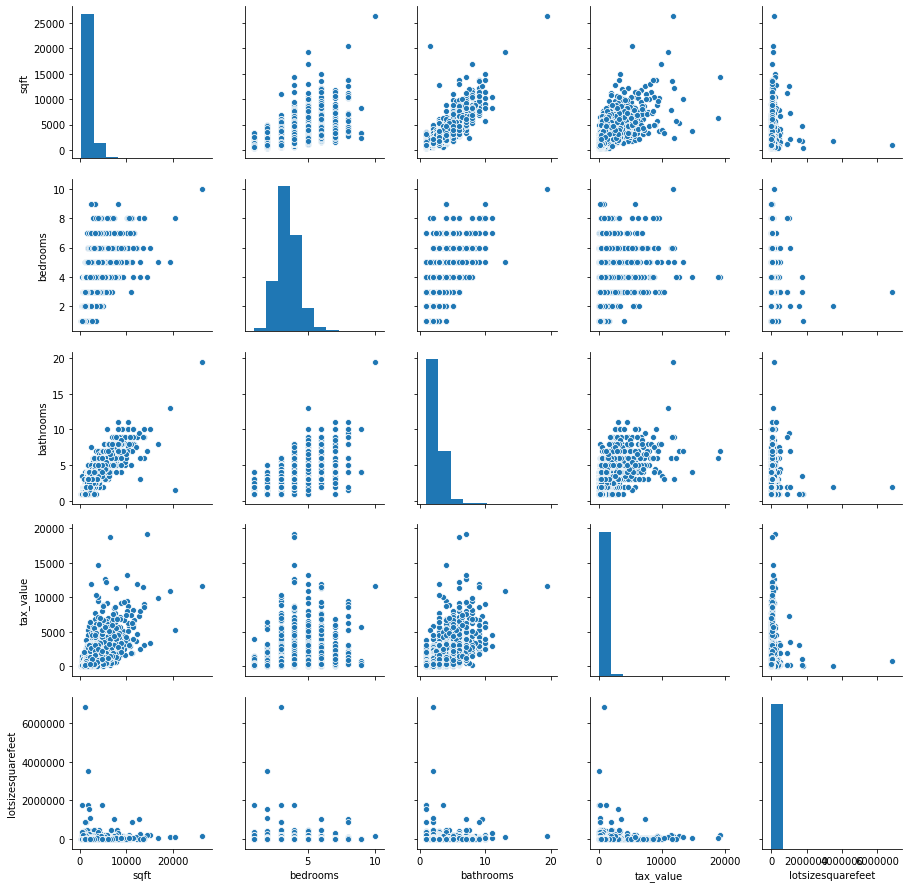

In [30]:
sns.pairplot(X_train,vars=['sqft','bedrooms','bathrooms','tax_value','lotsizesquarefeet'])

In [31]:
X_train.describe()

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,cluster
count,40908.00000,40908.000000,40908.000000,40908.000000,4.090800e+04,40908.000000,40908.000000,40908.000000
mean,2.24802,3.308253,1863.179011,454.901601,9.999098e+03,1960.965972,177.001557,0.029334
std,0.98528,0.912761,963.385702,579.912696,4.588718e+04,21.790502,227.353295,0.339639
min,1.00000,1.000000,320.000000,9.762000,1.976807e+02,1862.000000,0.100000,0.000000
25%,2.00000,3.000000,1262.000000,187.470000,5.676000e+03,1949.000000,75.472500,0.000000
50%,2.00000,3.000000,1625.000000,328.807000,6.783000e+03,1958.000000,123.187000,0.000000
75%,3.00000,4.000000,2203.000000,529.740000,8.580000e+03,1975.000000,203.916000,0.000000
max,19.50000,10.000000,26345.000000,19129.816000,6.845666e+06,2016.000000,8225.708000,4.000000


In [32]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_train, y_train)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X_train.columns)


print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 2.279308
Best score using built-in LassoCV: 0.000000
Lasso picked 0 variables and eliminated the other 8 variables


In [33]:
coef.sort_values()

bathrooms                     0.0
bedrooms                      0.0
sqft                          0.0
tax_value                    -0.0
lotsizesquarefeet             0.0
yearbuilt                    -0.0
structuretaxvaluedollarcnt   -0.0
cluster                      -0.0
dtype: float64

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings

In [35]:
from sklearn.linear_model import LinearRegression

lm1 = LinearRegression()

print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [43]:
lm1.fit(X_train, y_train)
print("Linear Model:", lm1)

lm1_y_intercept = lm1.intercept_
print("intercept: ", lm1_y_intercept)

lm1_coefficients = lm1.coef_
print("coefficients: ", lm1_coefficients)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [0.12783414]
coefficients:  [[ 3.71014412e-03  1.07361733e-03 -3.16485741e-06 -5.64459442e-06
   3.24422217e-09 -5.97832695e-05  1.23430151e-05 -2.36987749e-04]]


In [44]:
y_pred_lm1 = lm1.predict(X_train)

In [45]:
train.describe()

,bathrooms,bedrooms,sqft,tax_value,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,logerror
count,40908.00000,40908.000000,40908.000000,4.090800e+04,40908.000000,4.090800e+04,4.090800e+04,4.090800e+04,40908.000000,40908.000000,40908.000000,40908.000000,4.090800e+04,40908.000000
mean,2.24802,3.308253,1863.179011,4.549016e+05,6048.880219,3.401581e+07,-1.182066e+08,9.999098e+03,35722.960668,2559.680209,96601.195463,1960.965972,1.770016e+05,0.016239
std,0.98528,0.912761,963.385702,5.799127e+05,21.297927,2.470789e+05,3.515319e+05,4.588718e+04,54537.448332,787.182898,4514.155635,21.790502,2.273533e+05,0.168010
min,1.00000,1.000000,320.000000,9.762000e+03,6037.000000,3.334071e+07,-1.194484e+08,1.976807e+02,3491.000000,1286.000000,95982.000000,1862.000000,1.000000e+02,-3.737018
25%,2.00000,3.000000,1262.000000,1.874700e+05,6037.000000,3.383799e+07,-1.184014e+08,5.676000e+03,12447.000000,2061.000000,96193.000000,1949.000000,7.547250e+04,-0.024478
50%,2.00000,3.000000,1625.000000,3.288070e+05,6037.000000,3.401806e+07,-1.181587e+08,6.783000e+03,24832.000000,3101.000000,96389.000000,1958.000000,1.231870e+05,0.006530
75%,3.00000,4.000000,2203.000000,5.297400e+05,6059.000000,3.418054e+07,-1.179499e+08,8.580000e+03,44833.000000,3101.000000,96987.000000,1975.000000,2.039160e+05,0.039257
max,19.50000,10.000000,26345.000000,1.912982e+07,6111.000000,3.480695e+07,-1.175719e+08,6.845666e+06,396556.000000,3101.000000,399675.000000,2016.000000,8.225708e+06,3.123634


In [36]:
#kmeans =KMeans(n_clusters=5)
#kmeans.fit(X_train[['sqft','tax_value']])
#y_train['cluster'] =kmeans.predict(y_train)

#11/7 Error; Did you mean:
#X_train['cluster']=kmeans.predict(X_train[['sqft','tax_value']])
#y_train["cluster"]=kmeans.predict(X_train)

#or

#kmeans.fit(y_train)
#y_train["cluster"]= kmeans.predict(y_train)


ValueError: Incorrect number of features. Got 1 features, expected 2

In [56]:
def target_cluster(y_train,X_train):
    kmeans =KMeans(n_clusters=5)
    kmeans.fit(y_train)
    y_train['cluster'] = kmeans.predict(y_train)
    train = X_train.merge(y_train,left_index=True,right_index=True)
    return train

In [50]:
#def target_cluster(X_train, y_train):
#    kmeans = KMeans(n_clusters=5)
#    kmeans.fit(y_train)
#    y_train['cluster_y'] = kmeans.predict(y_train)
#    train = X_train.join(y_train)
#    return train
#Better way foward? Does not leave cluster_y and cluster_x column. Also dropped y_train cluster column
#prior to execution, not sure if you'd like all these columns. 

target_cluster()

In [187]:
train = target_cluster(y_train,X_train)

In [183]:
#y_train['cluster'] = kmeans.predict(y_train)


In [188]:
train.groupby('cluster').mean().sort_values(by='logerror')
#Error: Cluster does not exist as it was replaced by cluster_x and cluster_y, please refer to cell 50
#for recommended way forward.
train.head()

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror,cluster
12854,2.0,3.0,1838.0,216.159,9796.0,1999.0,172.934,0.051355,0
6103,2.0,3.0,2306.0,181.378,10306.0,1968.0,109.124,0.005659,0
46884,2.0,3.0,1482.0,304.562,6461.0,1924.0,196.565,0.052020,0
33177,3.0,4.0,1548.0,220.704,7113.0,1954.0,122.037,0.093799,0
43799,2.0,3.0,1338.0,354.795,5998.0,1950.0,89.675,-0.066423,0


In [116]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#train = pd.DataFrame(scaler.fit_transform(train),columns=train.logerror)
scaled_logerror = df[['logerror']]
scaled_logerror['scaled_logerror'] = pd.DataFrame(scaler.fit_transform(scaled_logerror))
train = train.merge(scaled_logerror,left_index=True,right_index=True)

train.head()

,bathrooms,bedrooms,sqft,tax_value,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,logerror_x,logerror_y,scaled_logerror
12854,2.0,3.0,1838.0,216159.0,6037.0,34613754.0,-118209598.0,9796.0,40227.0,3101.0,97329.0,1999.0,172934.0,0.051355,0.051355,0.468572
6103,2.0,3.0,2306.0,181378.0,6037.0,33764859.0,-118414326.0,10306.0,33311.0,3101.0,96121.0,1968.0,109124.0,0.005659,0.005659,0.466979
46884,2.0,3.0,1482.0,304562.0,6037.0,34153101.0,-118231483.0,6461.0,45457.0,3101.0,96325.0,1924.0,196565.0,0.052020,0.052020,0.471910
33177,3.0,4.0,1548.0,220704.0,6037.0,34216166.0,-118421991.0,7113.0,12447.0,3101.0,96450.0,1954.0,122037.0,0.093799,0.093799,0.467743
43799,2.0,3.0,1338.0,354795.0,6037.0,34205923.0,-118511561.0,5998.0,12447.0,3101.0,96415.0,1950.0,89675.0,-0.066423,-0.066423,0.463667


In [190]:
train.groupby('cluster').mean().sort_values(by='logerror')

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror
cluster,,,,,,,,
4,2.202970,3.178218,1861.089109,491.927634,10199.396040,1958.336634,175.277515,-1.206134
1,2.227414,3.297248,1858.903686,448.738298,10403.416123,1960.710021,174.941853,-0.162688
0,2.248212,3.308376,1862.095448,455.413786,9970.218409,1960.999487,176.784914,0.015529
2,2.292669,3.334479,1898.924399,460.900275,9847.796136,1961.163230,187.861656,0.367101
3,2.241803,3.352459,1799.959016,385.694328,7538.578448,1958.762295,150.343418,1.860403


In [195]:


from scipy.stats import ttest_ind, norm
train.head()
ttest_ind(train[(train.cluster == 3)].bedrooms,train[(train.cluster ==0)].bedrooms)

Ttest_indResult(statistic=0.5326386566367133, pvalue=0.5942870989578148)

In [63]:
#pd.DataFrame(.cluster_centers_, columns=train_c.columns)\
#    .reset_index()\
#    .rename({'index': 'cluster'}, axis=1)\
#    .set_index('cluster')
#11/7: ?

train.sort_values(by='tax_value')

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror_x,cluster,logerror_y,scaled_logerror,qcut
42838,1.0,2.0,572.0,9.762,4000.000000,1920.0,3.586000,0.077312,3,0.077312,0.469421,1
47332,1.0,2.0,676.0,10.301,4675.000000,1923.0,5.361000,0.162725,3,0.162725,0.487950,1
17383,2.0,3.0,1363.0,11.291,8028.000000,1901.0,4.550000,0.198187,0,0.198187,0.461082,1
37061,1.0,3.0,1212.0,11.453,5408.000000,1947.0,5.123478,0.043221,3,0.043221,0.465427,1
14404,1.0,2.0,578.0,11.539,4025.000000,1911.0,8.257000,0.083284,3,0.083284,0.454337,1
36793,1.0,2.0,634.0,12.168,2248.000000,1948.0,8.048000,0.158293,3,0.158293,0.470131,1
20378,1.0,3.0,980.0,12.545,2550.000000,1926.0,9.838000,0.006580,3,0.006580,0.475777,1
36543,1.0,2.0,572.0,12.788,1618.000000,1925.0,7.223000,-0.086106,1,-0.086106,0.471687,1
26099,1.0,2.0,720.0,13.197,2404.000000,1926.0,8.257000,0.000343,3,0.000343,0.480014,1
36579,1.0,1.0,524.0,13.479,2239.000000,1920.0,7.138000,0.287079,0,0.287079,0.466068,1


In [62]:
#train_c.groupby('cluster').mean().sort_values(by='logerror')
#11/7: train_c does not exist

In [63]:
#train_c.shape
#11/7: train_c does not exist

In [70]:
#ax = sns.swarmplot(x='cluster',y='sqft',data=train_c)
#11/7: train_c does not exist

In [69]:
#for i in train['qcut'].unique().tolist():
#    mean = train[train['qcut'] == i].logerror.mean()
#    std = train[train['qcut'] == i].logerror.std()
#    x = np.linspace(mean-.5,mean+.5,1000)
#    y = norm.pdf(x, loc=mean, scale=std)
#    plt.plot(x,y, label = i)
#11/7: reference below: scaled_logerror was the change

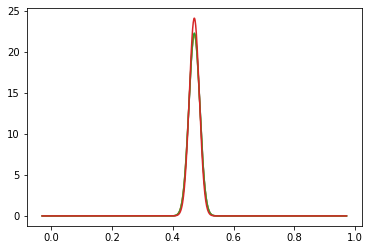

In [72]:
for i in train['qcut'].unique().tolist():
    mean = train[train['qcut'] == i].scaled_logerror.mean()
    std = train[train['qcut'] == i].scaled_logerror.std()
    x = np.linspace(mean-.5,mean+.5,1000)
    y = norm.pdf(x, loc=mean, scale=std)
    plt.plot(x,y, label = i)

In [175]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
from sklearn.feature_selection import RFE

#target_cluster(df['sqft','']

model = LinearRegression()
rfe = RFE(model,4)
X_rfe = rfe.fit_transform(X_train,y_train)


In [176]:
#model.fit(X_rfe,y_train)

In [177]:
cols = list(X_train.columns)
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['bathrooms', 'bedrooms', 'yearbuilt', 'structuretaxvaluedollarcnt'], dtype='object')


In [178]:
from sklearn.linear_model import LassoCV

reg = LassoCV()
reg.fit(X_train, y_train)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X_train.columns)


print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Best alpha using built-in LassoCV: 2.279308
Best score using built-in LassoCV: 0.000000
Lasso picked 0 variables and eliminated the other 7 variables


In [ ]:
number_of_features = features.optimal_number_of_features(X_train, y_train, 
                                        X_test, y_test)

selected_features = features.optimal_features(X_train, y_train, number_of_features)